## Degenerate Unmixing Estimation Technique

**Objectives**: Understand how spatial diversity in anechoic acoustic recordings can be used to build binary time-frequency masks for source separation. Implement the Degenerate Unmixing Estimation Technique (DUET).

### 0. Generation of an anechoic mixture of speech signals

Based on what you've done in the previous section, we are now going to generate a stereophonic anechoic mixture of $J=3$ speech source signals, that you will then unmix using DUET algorithm.

In [1]:
import matplotlib
import IPython.display as ipd
import numpy as np
import soundfile as sf 
import matplotlib.pyplot as plt
import scipy as sp
import librosa
import librosa.display
import os
from utils import plot_recording_config

In [2]:
# parameters

fs = 16000 # sampling rate in Hz

wlen_sec = 32e-3 # STFT window length in seconds
hop_percent = .5 # hop size as a percent of the window length
wlen = int(wlen_sec*fs) # window length in samples
wlen = np.int(np.power(2, np.ceil(np.log2(wlen)))) # next power of 2
F = wlen//2+1 # number of non-redundant frequency bins
hop = np.int(hop_percent*wlen) # hop size in samples
win = np.sin(np.arange(.5,wlen-.5+1)/wlen*np.pi); # sine analysis window

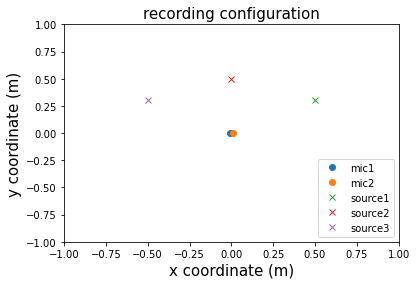

In [3]:
# recording configuration

q_m1 = np.array([-1e-2, 0]) # 1st microphone cartesian coordinates
q_m2 = np.array([1e-2, 0]) # 2nd microphone cartesian coordinates
q_s = np.array([[.5, .3],
               [0, .5],
               [-.5, .3]]).T # source cartesian coordinates, shape (2, 3)

plot_recording_config(q_m1, q_m2, q_s)

In [4]:
# ITD and ILD computation

d1 = np.linalg.norm(q_m1[:,np.newaxis] - q_s, axis=0) # sources-to-1st microphone distance
d2 = np.linalg.norm(q_m2[:,np.newaxis] - q_s, axis=0) # sources-to-2nd microphone distance

c = 344 # sound velocity in m/s

a = d1/d2 # inter-microphone level ratio
delta_sec = (d2 - d1)/c # time difference of arrival in seconds
delta = delta_sec*fs

print('Attenuations: %.2f, %.2f, %.2f' % tuple(a))
print('Delays: %.2f, %.2f, %.2f' % tuple(delta))

Attenuations: 1.03, 1.00, 0.97
Delays: -0.80, 0.00, 0.80


We now create a mixture of speech signals based on the recording configuration previously specified. 

Text(0, 0.5, 'amplitude')

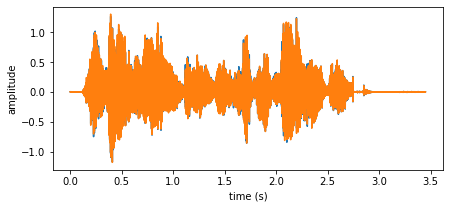

In [5]:
from utils import create_mixture, anechoic_FD_auralization
# The function ```create_mixture``` creates a mixture signal given a list of
# monophonic source signals, the auralization parameters (attenuation and delays) 
# and STFT parameters. It uses the ```anechoic_FD_auralization``` function you 
# worked on in the previous activity.

data_path = './data'

source_wavefiles = ['voice_woman_1.wav', 'voice_man_1.wav','voice_woman_2.wav']
source_wavefiles = [os.path.join(data_path, wavefile) for wavefile in source_wavefiles]

J = len(source_wavefiles)

x = create_mixture(anechoic_FD_auralization, source_wavefiles, a, delta, wlen, hop, win)
T = x.shape[0]

time_vec = np.arange(T)/fs

plt.figure(figsize=(7,3))
plt.plot(time_vec, x)
plt.xlabel('time (s)')
plt.ylabel('amplitude')

Listen to the resulting mixture signal.

In [6]:
ipd.Audio([x[:,0], x[:,1]], rate=fs) 

### 1 DUET - Theory

**Acknowledgements**: The following presentation of DUET is largely inspired from [S. Rickard, "The DUET Blind Source Separation
Algorithm", 2007](https://pdfs.semanticscholar.org/1413/746141f2871e0f45056a7696e019b8f8a100.pdf). 

---

Our objective is now to separate the individual speech source signals from their anechoic stereophonic mixture. This is an under-determined (or degenerate) source sepration problem. As we have more sources than microphones, we have to estimate more variables than equations.

We will use DUET, the Degenerate Unmixing Estimation Technique, whose principle can be summarized in one sentence: 

**It is possible to blindly separate an arbitrary number of sources given
just two anechoic mixtures provided the time–frequency representations of the sources do not overlap too much, which is a reasonable assumption for speech signals.**

**Notations**: Let $S_{j}(f,n)$ denote the STFT of the $j$-th source signal, with $j \in \{1, ... J\}$. We first consider a monophonic mixture signal: 
$$X(f,n) = \sum_{j=1}^J S_{j}(f,n).$$

#### 1.1 Binary masking and W-disjoint orthogonality

 We assume that the source signals have disjoint time-frequency supports. That is, **at a given time-frequency point $(f,n)$, we cannot have more than one source signal with an STFT coefficient that is is non-zero**. This hypothesis is called "W-disjoint orthogonality" and can be formalized by:

$$S_{j}(f,n)S_{k}(f,n) = 0, \qquad \forall (f,n), \qquad \forall j \neq k.$$ 

This assumption is the mathematical idealization of the condition that it is likely that every time–frequency point in the mixture with significant energy is dominated by the contribution of one source.

W-disjoint orthogonality is crucial to DUET because it allows for the separation of a mixture into its component sources using a **binary mask**:

$$ S_{j}(f,n) = M_{j}(f,n) X(f,n),$$

where the mask is defined by:
 
\begin{equation*}
M_j(f,n) = \begin{cases}
1 & \text{if } S_{j}(f,n) \neq 0 \\
0 & \text{otherwise} \\
\end{cases}.
\end{equation*}
 
But of course, in practice we do not know the mask as we do not have access to the individual source signals. The question is therefore, how do we determine the masks from the observation of the mixture signal? As we are going to see, **DUET exploits the spatial diversity of the anechoic acoustic recording to build the masks**.

#### 1.2 Anechoic stereophonic mixture

We consider an anechoic stereophonic mixture **model** defined by:

\begin{equation*}
\begin{bmatrix} X_{1}(f, n) \\ X_{2}(f, n) \end{bmatrix} =
\begin{bmatrix} 1 & ... & 1 \\ a_1 \exp\left({-\imath 2 \pi \frac{f}{L} \delta_1}\right) & ... & a_J \exp\left({-\imath 2 \pi \frac{f}{L} \delta_J}\right) \end{bmatrix}
\begin{bmatrix} S_{1}(f, n) \\ \vdots \\ S_{J}(f, n) \end{bmatrix}. \qquad (2)
\end{equation*}

We further assume that the sources have **different spatial locations**, so that:

$$(a_j \neq a_k) \text{ or } (\delta_j \neq \delta_k) \qquad \forall j \neq k.$$

Indeed, DUET is based on exploiting the spatial diversity in the mixture to estimate the binary masks for source separation.

With the further assumption of W-disjoint orthogonality, **at most one source is active at every time-frequency point**, and the mixture model can be rewritten as follows for all $(f,n)$ and for some source index $j$:

\begin{equation*}
\begin{bmatrix} X_{1}(f,n) \\ X_{2}(f,n) \end{bmatrix} =
\begin{bmatrix} 1 \\ a_j  \exp\left({-\imath 2 \pi \frac{f}{L} \delta_j}\right) \end{bmatrix} S_{j}(f, n).
\end{equation*}

#### 1.3 DUET algorithm

The main observation that DUET leverages is that **the ratio of the time–frequency representations of the mixtures does not depend on the source components but only on the mixing parameters associated with the active source component**:

$$\frac{X_{2}(f,n)}{X_{1}(f,n)} = a_j\exp\left({-\imath 2 \pi \frac{f}{L}\delta_j}\right), \qquad \forall (f, n) \in \Omega_j = \{(f,n),\, S_{j}(f,n) \neq 0\}.$$

The mixing parameters associated with each time-frequency point can be calculated by:

$$ \hat{a}(f,n) = \left|\frac{X_{2}(f,n)}{X_{1}(f,n)}\right|,$$

$$ \hat{\delta}(f,n) = -\frac{1}{2 \pi f/L}\arg\left(\frac{X_{2}(f,n)}{X_{1}(f,n)}\right), \qquad f > 0.$$

Under the assumption that the microphones are sufficiently close together so that the delay estimate is not incorrect due to phase wrapping, **the local attenuation and delay estimators** $\big(\hat{a}(f,n), \hat{\delta}(f,n)\big)$ **can only take values among the actual mixing parameters** $\{(a_j, \delta_j)\}_{j=1}^J$.

Therefore, we can build a 2D-histogram of the local attenuation and delay estimators to estimate the actual mixing parameters. **We can then associate each time-frequency point of the mixture signal to a given source, in order to perform source separation.**

More precisely, time-frequency masks are built as follows:
$$ M_j(f, n) =  \begin{cases}
1 & \text{if } \big(\hat{a}(f,n), \hat{\delta}(f,n)\big) = (a_j,\delta_j) \\
0 & \text{otherwise} \\
\end{cases}.$$

In practice, because not all of the assumptions are strictly satisfied, the local mixing parameter estimates will not be precisely equal to the mixing parameters, but they will cluster around the true values.

In summary, DUET consists in:

1. Construct the time–frequency representation of both mixtures.

2. Take the ratio of the two mixtures and extract local mixing parameter estimates.

3. Combine the set of local mixing parameter estimates into $J$ pairings corresponding to the true mixing parameter pairings.

4. Generate one binary mask for each determined mixing parameter pair corresponding to the time–frequency points which yield that particular mixing parameter pair.

5. Separate the sources by multiplying each mask with one of the mixtures.

6. Return each demixed time–frequency representation to the time domain.

### 2 DUET - Practice

**Acknowledgements**: Some pieces of code are inspired from [The Northwestern University Source Separation Library (nussl)](https://github.com/interactiveaudiolab/nussl).

---

You will now implemement the DUET algorithm. In the following cell, we first remove the leading and trailing silences in the mixture signal, because we can estimate the mixing parameters only for the portions of the mixture that contain speech.

#### 2.1 Local mixing parameters computation

In [7]:
x, _ = librosa.effects.trim(x.T, top_db=30) # remove leading and trailing silences in the mixture
x = x.T

**Exercise:**

In the following cell, you have to:

- compute the STFTs $X_1(f,n)$ and $X_2(f,n)$ of the left and right microphone signals, respectively.

- compute the local attenuation coefficients in dB:

    $$\hat{a}_{dB}(f,n) = 20 \log_{10} \hat{a}(f,n),$$

    where 

    $$ \hat{a}(f,n) = \left|\frac{X_{2}(f,n) + \epsilon}{X_{1}(f,n) + \epsilon}\right|,$$

    and $\epsilon = 10^{-10}$ is used to avoid dividing by zero.

- compute the local relative delay coefficients (apply the normalization only for $f > 0$):

$$\hat{\delta}(f,n) = -\frac{1}{2 \pi f/L}\arg\left(\frac{X_{2}(f,n)}{X_{1}(f,n)}\right).$$ 

__hint__: Use 'np.angle' to compute the argument of a complex number.

In [8]:
X_L = librosa.stft(x[:,0], n_fft=wlen, hop_length=hop, win_length=wlen, window=win)
X_R = librosa.stft(x[:,1], n_fft=wlen, hop_length=hop, win_length=wlen, window=win)

F, N = X_L.shape

########## TODO ###########

inter_channel_ratio = (X_R + 1e-10) / (X_L + 1e-10)

attenuation = np.abs(inter_channel_ratio) # relative attenuation between the two channels
attenuation_dB = 20*np.log10(attenuation)

f_vec = 2 * np.pi * np.arange(F) / wlen 
f_mat = f_vec[:, np.newaxis]

relative_delay = -np.angle(inter_channel_ratio)
relative_delay[1:,:] = relative_delay[1:,:] / f_mat[1:,:]  # relative delay

##########################

#### 2.2 2D histogram computation and peak picking

In the following cell, we plot a 2D histogram of the local mixing parameters $\Big\{ \big(\hat{a}_{dB}(f,n), \hat{\delta}(f,n)\big) \Big\}_{f,n}$ that you extracted. 

**Question**: What do you observe?

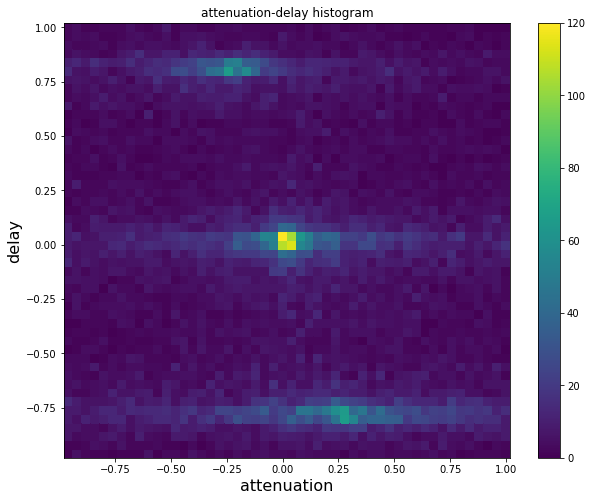

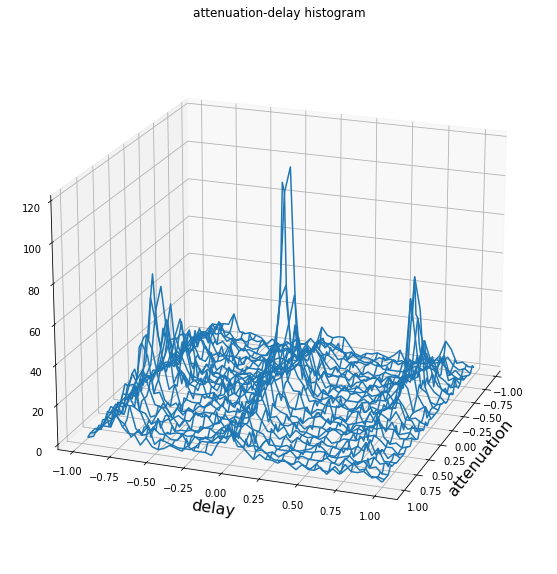

In [9]:
nbins_att = 50 # the number of bins for the attenuation dimension
nbins_delay = 50 # the number of bins for the delay dimension
bins_array = np.array([nbins_att, nbins_delay])

range_array = np.array([[-1, 1], [-1, 1]]) #The leftmost and rightmost edges of the bins along each dimension.
# All values outside of this range will be considered outliers and not counted in the histogram.

# compute the histogram
histogram, atn_bins, delay_bins = np.histogram2d(attenuation_dB.flatten(), relative_delay.flatten(), 
                                                 bins=bins_array, range=range_array)

atn_tile = np.tile(atn_bins[1:], (nbins_att, 1)).T
delay_tile = np.tile(delay_bins[1:].T, (nbins_delay, 1))

fig = plt.figure(figsize=(10,8))
plt.pcolormesh(atn_tile, delay_tile, histogram, shading='auto')
plt.xlabel('attenuation', fontsize=16)
plt.ylabel('delay', fontsize=16)
plt.title('attenuation-delay histogram')
plt.axis('tight')
plt.colorbar()

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(atn_tile, delay_tile, histogram, rstride=2, cstride=2)
plt.xlabel('attenuation', fontsize=16)
plt.ylabel('delay', fontsize=16)
plt.title('attenuation-delay histogram')
plt.axis('tight')
ax.view_init(20, 20)

In the following cell, we extract the peaks of the 2D histogram in order to estimate the mixing parameters $\{(\hat{a}_j, \hat{\delta}_j)\}_{j=1}^J$.

In [10]:
from utils import find_peak_indices

peak_indices = find_peak_indices(histogram, J, threshold=0.2, min_dist=[5,5])

atn_indices = [x[0] for x in peak_indices]
delay_indices = [x[1] for x in peak_indices]

atn_peak_dB = atn_bins[atn_indices] # attenuation estimates in dB scale, shape (J,)
atn_peak = 10**(atn_peak_dB/20)  # attenuation estimates in linear scale, shape (J,)

delay_peak = delay_bins[delay_indices] # relative delay estimates, shape (J,)

print('Estimated attenuations: %.2f, %.2f, %.2f' % tuple(atn_peak))
print('Estimated delays: %.2f, %.2f, %.2f' % tuple(delay_peak))

Estimated attenuations: 1.00, 0.97, 1.03
Estimated delays: 0.00, 0.76, -0.84


**Question**: Compare the estimated values with the true ones from the definition of the recording configuration.

#### 2.3 Binary masking

Once the peaks have been identified, our goal is to determine the time–frequency masks which will separate each source from the mixtures. This is achieved by assigning each time–frequency point $(f,n)$ to the source of index $j \in \{1,...,J\}$ whose peak $(\hat{a}_j, \hat{\delta}_j)$ is closest to the local parameter estimates $\big(\hat{a}(f,n), \hat{\delta}(f,n)\big)$.

More precisely, we build the time-frequency masks as follows:

$$ M_j(f, n) =  \begin{cases}
1 & \text{if } \mathcal{J}(f,n) = j \\
0 & \text{otherwise} \\
\end{cases},$$

where $\mathcal{J}(f,n)$ is defined by

$$ \mathcal{J}(f,n) = \underset{j \in \{1,...,J\}}{\operatorname{argmin}} \left| \hat{a}_j  \exp\left({-\imath 2 \pi \frac{f}{L} \hat{\delta}_j}\right) - \hat{a}(f,n) \exp\left({-\imath 2 \pi \frac{f}{L} \hat{\delta}(f,n)}\right) \right|^2 $$

In the following cell, we compute the masks by applying this procedure. In particular, we use ```np.argmin``` to find the source index that minimizes the above cost.

In [11]:
masks = np.zeros((F, N, J))

f_vec = 2 * np.pi * np.arange(F) / wlen 
f_mat = f_vec[:, np.newaxis]

for f in np.arange(F):
    for n in np.arange(N):
        
        cost = np.abs(atn_peak * np.exp(-1j * f_mat[f] * delay_peak) - 
                      attenuation[f,n] * np.exp(-1j * f_mat[f] * relative_delay[f,n]) )**2
        
        j = np.argmin(cost)
        masks[f,n,j] = 1

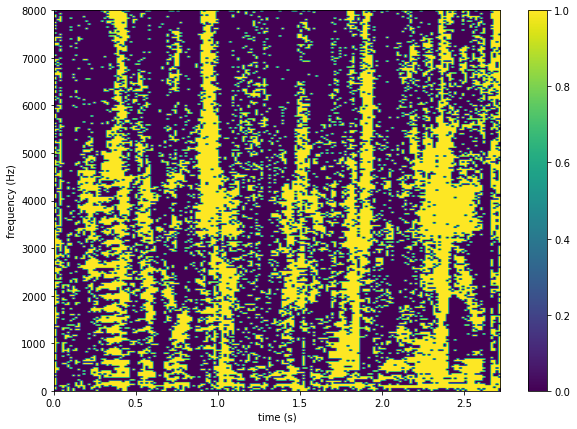

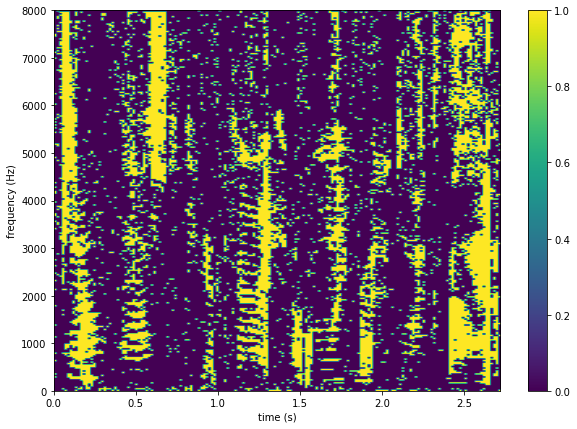

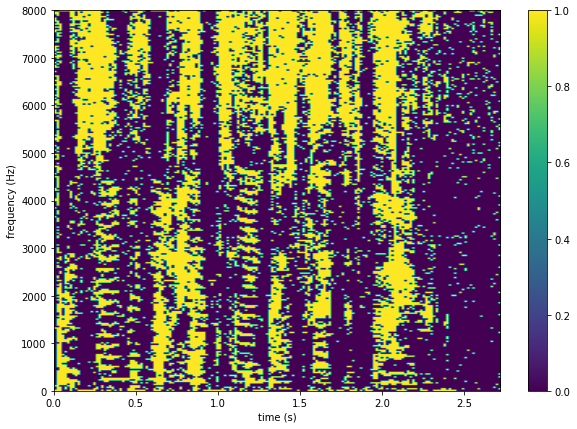

In [12]:
# Plot the masks
for j in np.arange(J):   
    plt.figure(figsize=(10,7))
    plt.imshow(masks[:,:,j], origin='lower', aspect='auto', extent=[0, (N-1)*hop/fs, 0, fs/2])
    plt.xlabel('time (s)')
    plt.ylabel('frequency (Hz)')
    plt.colorbar()

#### 2.4 Source separation

**Exercise:** 

Apply the binary masks to the mixture (use the left microphone signal only) in order to compute the STFT of the individual source signals.

In [13]:
S_est = np.zeros((F,N,J), dtype='complex')

########## TODO ###########

for j in np.arange(J):
    S_est[:,:,j] = masks[:,:,j] * X_L
    
##########################

The separated waveforms are then recovered by inverse STFT.

In [14]:
s_est = np.zeros((T,J))

for j in np.arange(J):
    s_est[:, j] = librosa.istft(S_est[:,:,j], hop_length=hop, win_length=wlen, window=win, length=T)

Listen to the separated sources.

In [15]:
ipd.Audio(s_est[:, 0], rate=fs) 

In [16]:
ipd.Audio(s_est[:, 1], rate=fs) 

In [17]:
ipd.Audio(s_est[:, 2], rate=fs) 